In [1]:
%cd ../../../

/Users/nseverin/MyData/Projects/Science/LLM/sasrec-bert4rec-recsys23


/Users/nseverin/MyData/Projects/Science/LLM/sasrec-bert4rec-recsys23/venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from collections import defaultdict
import re
import numpy as np
import pandas as pd



def open_text(filename): 
    with open(filename) as f:
        return f.read()


def parse_file_simple(log_data):
    epoch_pattern = re.compile(r"Epoch (\d+)/\d+ | Train Total Loss: ([\d.]+)")
    metrics_pattern = re.compile(r"(Validation|Test) Metrics: ({.+?})")
    
    # Parse the log
    results = defaultdict(lambda: {"validation_metrics": [], "test_metrics": []})
    
    for line in log_data.splitlines():        
        epoch_match = epoch_pattern.search(line)
        if epoch_match:
            epoch_num = int(epoch_match.group(1))
            loss = float(epoch_match.group(2))
        
        metrics_match = metrics_pattern.search(line)
        if metrics_match:
            metric_type = metrics_match.group(1).lower()  # "validation" or "test"
            metrics = eval(metrics_match.group(2))  # Convert string to dict
            results['simple'][f"{metric_type}_metrics"].append({"epoch": epoch_num, "loss": loss, **metrics})
    return results


def parse_file_llm(log_data):
    # Regex patterns
    config_pattern = re.compile(r"experiments(.+?\.yaml)")
    epoch_pattern = re.compile(r"Epoch: (\d+)/\d+ \| Train Total Loss: ([\d.]+)")
    metrics_pattern = re.compile(r"(Validation|Test) Metrics: ({.+?})")
    
    # Parse the log
    results = defaultdict(lambda: {"validation_metrics": [], "test_metrics": []})
    current_config = None
        
    for line in log_data.splitlines():
        config_match = config_pattern.search(line)
        if config_match:
            current_config = config_match.group(1)
        
        epoch_match = epoch_pattern.search(line)
        if epoch_match:
            print(epoch_match.group(1))
            epoch_num = int(epoch_match.group(1))
            loss = float(epoch_match.group(2))
        
        metrics_match = metrics_pattern.search(line)
        if metrics_match and current_config:
            metric_type = metrics_match.group(1).lower()  # "validation" or "test"
            metrics = eval(metrics_match.group(2))  # Convert string to dict
            results[current_config][f"{metric_type}_metrics"].append({"epoch": epoch_num, "loss": loss, **metrics})
    return results


def find_max(results, config, metric='NDCG@10'):
    def get_dct_epoch(lst, epoch):
        for x in lst:
            if x['epoch'] == epoch:
                return x
        return lst[-1]
        # raise Exception()
    
    def postprocess(lst):
        res = []
        for dct in lst:
            res.append({
                'NDCG@10': round(dct['NDCG@10'], 5),
                'Recall@10': round(dct['Recall@10'], 5),
                'epoch': dct['epoch']
            })
        return res
    
    best_val_dct = None
    for dct in results[config]['validation_metrics']:
        if best_val_dct is None:
            best_val_dct = dct
        elif dct[metric] > best_val_dct[metric]:
            best_val_dct = dct
    
    best_val_epoch = best_val_dct['epoch']
    
    return {
        'test': postprocess([get_dct_epoch(results[config]['test_metrics'], best_val_epoch)]),
        'validation': postprocess([best_val_dct]),
    }


def create_dataframe(exp_data_with_max_val):
    # List to store extracted experiment data
    data = []
    
    # Parse experiment results
    for config_path, metrics in exp_data_with_max_val.items():
        # Extract config details from the filename
        config_file = config_path.split("/")[-1]  # Get only the filename
        config_name = config_file.replace(".yaml", "").lstrip('sasrec-').split("-")
        
        hidden_units = int(config_name[0])
        num_blocks = int(config_name[1])
        num_heads = int(config_name[2])
        dropout_rate = float(config_name[3])
        learning_rate = float(config_name[4])
        seed = int(config_name[5]) if len(config_name) == 6 else 42
        
        # Extract validation and test metrics
        val_metrics = metrics.get("validation", [{}])[0]
        test_metrics = metrics.get("test", [{}])[0]
    
        # Append extracted values to data list
        data.append([
            config_file, hidden_units, num_blocks, num_heads, dropout_rate, learning_rate, seed,
            val_metrics.get("NDCG@10", None), val_metrics.get("Recall@10", None), val_metrics.get("epoch", None),
            test_metrics.get("NDCG@10", None), test_metrics.get("Recall@10", None), test_metrics.get("epoch", None)
        ])
    
    # Create DataFrame
    columns = [
        "config_file", "hidden_units", "num_blocks", "num_heads", "dropout_rate", "learning_rate", "seed",
        "val_NDCG@10", "val_Recall@10", "val_epoch", "test_NDCG@10", "test_Recall@10", "test_epoch"
        ]
    
    df = pd.DataFrame(data, columns=columns)
    return df


PARAMS = ['hidden_units', 'num_blocks', 'num_heads', 'dropout_rate', 'learning_rate']



def apply_seed_info(df):
    df['params'] = df.apply(lambda row: (row['hidden_units'],
                                         row['num_blocks'], 
                                         row['num_heads'],
                                         row['dropout_rate'], 
                                         row['learning_rate']), axis=1)
    params2seeds = {}
    for params, seed in zip(df['params'], df['seed']):
        if params not in params2seeds:
            params2seeds[params] = []
        params2seeds[params].append(seed)
    df['all_seeds'] = df.apply(lambda row: (params2seeds[row['params']]), axis=1)
    return df

In [3]:
MODEL_NAME = 'bert4rec'
DATASET = 'kion_en'
EXPERIMENT_NAME = 'baseline'
SPLIT_NAME = 'general'
MODE = 'BASELINE'

local_directory = f"experiments-2_0/results/{MODEL_NAME}/{DATASET}/{EXPERIMENT_NAME}" 

seed_folders = ['single_seed', 'other_seed']

In [4]:
import os


results = {}
for seed_folder in seed_folders:
    cur_folder = os.path.join(local_directory, seed_folder)
    for file in os.listdir(cur_folder):
        log_data = open_text(f'{cur_folder}/{file}')
        cur_results = parse_file_llm(log_data)
        # if cur_results['simple']['validation_metrics'] == []:
        #     continue
        results.update(cur_results)
    
    
exp_data_with_max_val = {}
for config in results:
    exp_data_with_max_val[config] = find_max(results, config, metric='NDCG@10')
exp_data_with_max_val.keys()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
1

dict_keys(['-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-2-0.2-0.0005-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-2-0.2-0.001-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-2-0.3-0.0005-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-2-0.3-0.001-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-4-0.2-0.0005-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-4-0.2-0.001-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-4-0.3-0.0005-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/128-4-4-0.3-0.001-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/64-2-2-0.2-0.0005-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/64-2-2-0.2-0.001-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/64-2-2-0.3-0.0005-42.yaml', '-2_0/configs/bert4rec/kion_en/baseline/single_seed/64-2-2-0.3-0.001-42.yaml', '-2_0/configs/bert4rec/kion

In [5]:
df = create_dataframe(exp_data_with_max_val)
df

,config_file,hidden_units,num_blocks,num_heads,dropout_rate,learning_rate,seed,val_NDCG@10,val_Recall@10,val_epoch,test_NDCG@10,test_Recall@10,test_epoch
0,128-4-2-0.2-0.0005-42.yaml,128,4,2,0.2,0.0005,42,0.09437,0.17018,13,0.05776,0.10826,13
1,128-4-2-0.2-0.001-42.yaml,128,4,2,0.2,0.0010,42,0.09500,0.17203,14,0.05643,0.10653,14
2,128-4-2-0.3-0.0005-42.yaml,128,4,2,0.3,0.0005,42,0.09445,0.17258,27,0.05738,0.11044,27
3,128-4-2-0.3-0.001-42.yaml,128,4,2,0.3,0.0010,42,0.09489,0.17372,26,0.05765,0.11119,26
4,128-4-4-0.2-0.0005-42.yaml,128,4,4,0.2,0.0005,42,0.09384,0.17089,19,0.05540,0.10345,19
5,128-4-4-0.2-0.001-42.yaml,128,4,4,0.2,0.0010,42,0.09424,0.17035,20,0.05643,0.10529,20
6,128-4-4-0.3-0.0005-42.yaml,128,4,4,0.3,0.0005,42,0.09381,0.17008,19,0.05619,0.10642,19
7,128-4-4-0.3-0.001-42.yaml,128,4,4,0.3,0.0010,42,0.09414,0.16866,30,0.05580,0.10701,30
8,64-2-2-0.2-0.0005-42.yaml,64,2,2,0.2,0.0005,42,0.09328,0.17111,22,0.05599,0.10694,22
9,64-2-2-0.2-0.001-42.yaml,64,2,2,0.2,0.0010,42,0.09270,0.17018,27,0.05633,0.10812,27


In [6]:
df

,config_file,hidden_units,num_blocks,num_heads,dropout_rate,learning_rate,seed,val_NDCG@10,val_Recall@10,val_epoch,test_NDCG@10,test_Recall@10,test_epoch
0,128-4-2-0.2-0.0005-42.yaml,128,4,2,0.2,0.0005,42,0.09437,0.17018,13,0.05776,0.10826,13
1,128-4-2-0.2-0.001-42.yaml,128,4,2,0.2,0.0010,42,0.09500,0.17203,14,0.05643,0.10653,14
2,128-4-2-0.3-0.0005-42.yaml,128,4,2,0.3,0.0005,42,0.09445,0.17258,27,0.05738,0.11044,27
3,128-4-2-0.3-0.001-42.yaml,128,4,2,0.3,0.0010,42,0.09489,0.17372,26,0.05765,0.11119,26
4,128-4-4-0.2-0.0005-42.yaml,128,4,4,0.2,0.0005,42,0.09384,0.17089,19,0.05540,0.10345,19
5,128-4-4-0.2-0.001-42.yaml,128,4,4,0.2,0.0010,42,0.09424,0.17035,20,0.05643,0.10529,20
6,128-4-4-0.3-0.0005-42.yaml,128,4,4,0.3,0.0005,42,0.09381,0.17008,19,0.05619,0.10642,19
7,128-4-4-0.3-0.001-42.yaml,128,4,4,0.3,0.0010,42,0.09414,0.16866,30,0.05580,0.10701,30
8,64-2-2-0.2-0.0005-42.yaml,64,2,2,0.2,0.0005,42,0.09328,0.17111,22,0.05599,0.10694,22
9,64-2-2-0.2-0.001-42.yaml,64,2,2,0.2,0.0010,42,0.09270,0.17018,27,0.05633,0.10812,27


In [7]:
df = apply_seed_info(df)
df.sort_values(by='val_NDCG@10', ascending=False, inplace=True)
df

,config_file,hidden_units,num_blocks,num_heads,dropout_rate,learning_rate,seed,val_NDCG@10,val_Recall@10,val_epoch,test_NDCG@10,test_Recall@10,test_epoch,params,all_seeds
41,128-4-2-0.2-0.001-256.yaml,128,4,2,0.2,0.0010,256,0.09539,0.17143,23,0.05591,0.10680,23,"(128, 4, 2, 0.2, 0.001)","[42, 1, 256]"
43,128-4-2-0.3-0.001-256.yaml,128,4,2,0.3,0.0010,256,0.09533,0.17350,27,0.05825,0.11044,27,"(128, 4, 2, 0.3, 0.001)","[42, 1, 256]"
44,128-4-4-0.2-0.001-1.yaml,128,4,4,0.2,0.0010,1,0.09532,0.17133,22,0.05629,0.10632,22,"(128, 4, 4, 0.2, 0.001)","[42, 1, 256]"
40,128-4-2-0.2-0.001-1.yaml,128,4,2,0.2,0.0010,1,0.09523,0.17182,19,0.05709,0.10707,19,"(128, 4, 2, 0.2, 0.001)","[42, 1, 256]"
37,128-2-4-0.2-0.001-256.yaml,128,2,4,0.2,0.0010,256,0.09503,0.17231,25,0.05632,0.10673,25,"(128, 2, 4, 0.2, 0.001)","[42, 1, 256]"
1,128-4-2-0.2-0.001-42.yaml,128,4,2,0.2,0.0010,42,0.09500,0.17203,14,0.05643,0.10653,14,"(128, 4, 2, 0.2, 0.001)","[42, 1, 256]"
3,128-4-2-0.3-0.001-42.yaml,128,4,2,0.3,0.0010,42,0.09489,0.17372,26,0.05765,0.11119,26,"(128, 4, 2, 0.3, 0.001)","[42, 1, 256]"
47,128-4-4-0.3-0.001-256.yaml,128,4,4,0.3,0.0010,256,0.09463,0.17247,27,0.05797,0.10899,27,"(128, 4, 4, 0.3, 0.001)","[42, 1, 256]"
2,128-4-2-0.3-0.0005-42.yaml,128,4,2,0.3,0.0005,42,0.09445,0.17258,27,0.05738,0.11044,27,"(128, 4, 2, 0.3, 0.0005)",[42]
42,128-4-2-0.3-0.001-1.yaml,128,4,2,0.3,0.0010,1,0.09439,0.17241,24,0.05757,0.10943,24,"(128, 4, 2, 0.3, 0.001)","[42, 1, 256]"


In [8]:
df_all = df[df['all_seeds'].apply(len) == 3]

In [9]:
def get_stats_seeds(df_all):
    metric_cols = ["val_NDCG@10", "val_Recall@10", "val_epoch", "test_NDCG@10", "test_Recall@10"]
        
    grouped_df = df_all.drop(['config_file', 'all_seeds', 'seed'], axis=1).groupby('params')
    df_mean = grouped_df.agg('mean')
    df_std = grouped_df.agg('std')
    for col in metric_cols:
        df_mean[col + '__std'] = df_std[col]
    return df_mean


def reorder_cols(df):
    order = ['val_epoch', 'val_epoch__std', 'hidden_units', 'num_blocks', 'num_heads', 'dropout_rate', 'learning_rate', 'val_NDCG@10', 'val_NDCG@10__std', 'val_Recall@10', 'val_Recall@10__std', 'test_NDCG@10', 'test_NDCG@10__std', 'test_Recall@10', 'test_Recall@10__std']
    return df[order]


df_all = df[df['all_seeds'].apply(len) == 3]
df_final = get_stats_seeds(df_all)
df_final = reorder_cols(df_final)
df_final.sort_values(by='test_NDCG@10', ascending=False, inplace=True)
df_final


# 0.045270
# 0.052483

,val_epoch,val_epoch__std,hidden_units,num_blocks,num_heads,dropout_rate,learning_rate,val_NDCG@10,val_NDCG@10__std,val_Recall@10,val_Recall@10__std,test_NDCG@10,test_NDCG@10__std,test_Recall@10,test_Recall@10__std
params,,,,,,,,,,,,,,,
"(128, 4, 2, 0.3, 0.001)",25.666667,1.527525,128.0,4.0,2.0,0.3,0.001,0.094870,0.000470,0.173210,0.000701,0.057823,0.000372,0.110353,0.000883
"(128, 2, 2, 0.3, 0.001)",24.666667,0.577350,128.0,2.0,2.0,0.3,0.001,0.092730,0.000707,0.170767,0.001256,0.057587,0.000491,0.108960,0.000545
"(128, 4, 4, 0.3, 0.001)",27.000000,3.000000,128.0,4.0,4.0,0.3,0.001,0.093693,0.001223,0.170110,0.002062,0.057167,0.001190,0.108023,0.000991
"(128, 4, 2, 0.2, 0.001)",18.666667,4.509250,128.0,4.0,2.0,0.2,0.001,0.095207,0.000196,0.171760,0.000304,0.056477,0.000591,0.106800,0.000270
"(128, 2, 4, 0.2, 0.001)",25.000000,0.000000,128.0,2.0,4.0,0.2,0.001,0.094380,0.000575,0.172253,0.000737,0.056420,0.001113,0.106547,0.001275
"(128, 4, 4, 0.2, 0.001)",23.000000,3.605551,128.0,4.0,4.0,0.2,0.001,0.094603,0.000621,0.170730,0.000526,0.056193,0.000297,0.105723,0.000534
"(128, 2, 2, 0.2, 0.001)",18.333333,2.309401,128.0,2.0,2.0,0.2,0.001,0.092553,0.000456,0.169007,0.001428,0.055970,0.000685,0.107263,0.001222
"(128, 2, 4, 0.3, 0.001)",28.333333,2.886751,128.0,2.0,4.0,0.3,0.001,0.091803,0.001001,0.170600,0.000915,0.055950,0.000788,0.106937,0.001664


array([<Axes: title={'center': 'val_NDCG@10'}, xlabel='learning_rate'>,
       <Axes: title={'center': 'test_NDCG@10'}, xlabel='learning_rate'>],
      dtype=object)

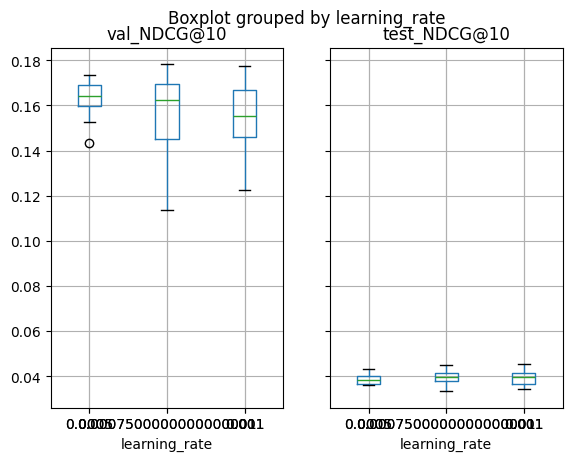

In [32]:
df_final.boxplot(column=['val_NDCG@10', 'test_NDCG@10'], by='learning_rate')

In [29]:
df[df['params'] == (256, 4, 8, 0.2, 0.00075)]

,config_file,hidden_units,num_blocks,num_heads,dropout_rate,learning_rate,seed,val_NDCG@10,val_Recall@10,val_epoch,test_NDCG@10,test_Recall@10,test_epoch,params,all_seeds
42,256-4-8-0.2-0.00075-42.yaml,256,4,8,0.2,0.00075,42,0.17929,0.28490,91,0.04604,0.07896,91,"(256, 4, 8, 0.2, 0.00075)","[42, 1, 256]"
126,256-4-8-0.2-0.00075-256.yaml,256,4,8,0.2,0.00075,256,0.17889,0.28459,92,0.04084,0.07173,92,"(256, 4, 8, 0.2, 0.00075)","[42, 1, 256]"
125,256-4-8-0.2-0.00075-1.yaml,256,4,8,0.2,0.00075,1,0.17705,0.28454,96,0.03923,0.07051,96,"(256, 4, 8, 0.2, 0.00075)","[42, 1, 256]"


In [25]:
df_final.columns 

Index(['val_epoch', 'val_epoch__std', 'hidden_units', 'num_blocks',
       'num_heads', 'dropout_rate', 'learning_rate', 'val_NDCG@10',
       'val_NDCG@10__std', 'val_Recall@10', 'val_Recall@10__std',
       'test_NDCG@10', 'test_NDCG@10__std', 'test_Recall@10',
       'test_Recall@10__std'],
      dtype='object')

In [9]:
df_final[PARAMS[1:]].to_json('RESULTS_LATE/ml20m_base.json', index=False, orient="records")

In [18]:
df_final.to_csv('ml20m_baseline_3seed_runs_NEW.csv', index=False)

In [11]:
df_final.to_csv('ml20m_baseline_FINAL_200_epochs.csv', index=True)

In [19]:
df.to_csv('ml20m_baseline_all_runs_NEW.csv', index=False)

In [8]:
# df.to_csv('kion_baseline_all_runs.csv', index=False)
df[PARAMS].to_json('ml20m_baseline_all_runs.json', index=False, orient="records")


In [56]:
grouped_df.get_group((128, 2, 2, 0.2, 0.0005))

,hidden_units,num_blocks,num_heads,dropout_rate,learning_rate,val_NDCG@10,val_Recall@10,val_epoch,test_NDCG@10,test_Recall@10,test_epoch,params
519,128,2,2,0.2,0.0005,0.02381,0.04742,11,0.01059,0.02176,11,"(128, 2, 2, 0.2, 0.0005)"
122,128,2,2,0.2,0.0005,0.02380,0.04668,14,0.01046,0.02176,14,"(128, 2, 2, 0.2, 0.0005)"
520,128,2,2,0.2,0.0005,0.02281,0.04608,11,0.00994,0.02027,11,"(128, 2, 2, 0.2, 0.0005)"


In [15]:
np.corrcoef(df_final['test_NDCG@10'].values[:15], df_final['val_NDCG@10'].values[:15])

array([[1.        , 0.27889656],
       [0.27889656, 1.        ]])